In [1]:
from __future__ import division, print_function

import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import numpy.ma as ma
from geopy.distance import vincenty, great_circle
import matplotlib.colors as colors
import warnings
import math

import scipy.linalg
from mpl_toolkits.mplot3d import Axes3D

from mpl_toolkits.basemap import cm,addcyclic,Basemap, shiftgrid
import warnings

# from salishsea_tools import (
#     nc_tools,
#     viz_tools,
# )

%matplotlib inline

## Wavenumber of the Topography
In this module I will use the data from processing2 to create a power density spectrum, then assign a wavenumber for each gridcell in the IBCAO domain.

The wavenumber will be determined by taking a weighted average of the all of the wavnumbers present in the spectra at a given amplitude. 

In [2]:
#ibcao2 = nc.Dataset('//ocean//jthibaul//research//data//IBCAO//IBCAO_V3_500m_RR.grd')
ibcao2 = nc.Dataset('/home/jacquielee/data/IBCAO_V3_500m_RR.grd')

ibcao2_x = ibcao2.variables['x']
ibcao2_y = ibcao2.variables['y']
ibcao2_z= ibcao2.variables['z']

In [3]:
#bathy2 = np.ma.masked_where(ibcao2_z[:,:] > 0.0,ibcao2_z)
bathy2 = ibcao2_z[:,:]
x10=ibcao2_x[::1,]
y10=ibcao2_y[::1,]
bathy10=bathy2[::1,::1]

print(bathy10.shape,x10.shape,y10.shape)
print(type(bathy10))

(11617, 11617) (11617,) (11617,)
<class 'numpy.ma.core.MaskedArray'>


In [4]:
bathy0 = np.ma.masked_where(bathy10[:,:] > 0.0,bathy10)

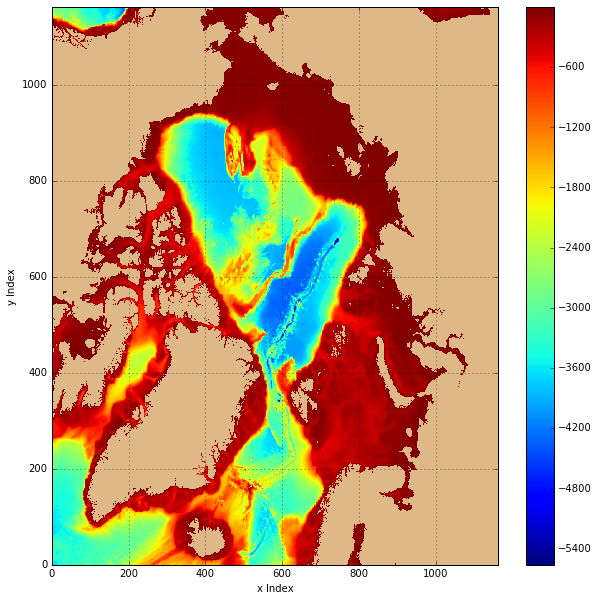

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
cmap = plt.get_cmap('jet')
cmap.set_bad('burlywood')
mesh = ax.pcolormesh(bathy0,cmap=cmap)
cbar = fig.colorbar(mesh,ax=ax)
plt.axis((0, bathy10.shape[1], 0, bathy10.shape[0]))
ax.grid()

ax.set_xlabel('x Index')
ax.set_ylabel('y Index')

In [5]:
# Create algorithm to calculate kappa
import spectrum
from scipy import signal
def kappa(bathy, x, y, length, direction):
    #bathy is 2D grid 
    #x and y are the coords corresponding to bathy
    #length is the number of grid cells kappa will be calculated over
    #direction is either 'x' or 'y' and is a string
    w_num = np.zeros_like(bathy)
    if direction == 'x':
#        r = len(bathy[0,:])-1 % length
        for i in np.arange(0, len(y[:])):
            for j in np.arange(0,len(x),length):

                if j+length < len(x):
                    end = j+length
                elif j+1 == len(x):
                    #print('if j is the last index in x')
                    w_num[i,j] = w_num[i,j-length]
                    break
                elif j+2 == len(x):
                    #print('if j is the second to last index in y')
                    w_num[i,j:j+1] = w_num[i,j-length]
                    break
                elif j+length > len(x):
                    #print('if j+length longer than x-array')
                    end = len(x)-1
                #print(end)
                data = data_grid(bathy,i,length,direction,j, end)
                #print(data)
                resid, distance = residuals2(data, i,x,y,direction,j, end)
                #print(resid)
                w_num[i,j:j+length] = pds(resid,bathy,i,direction,distance,j, end)
                #print(w_num)
    if direction == 'y':
        for i in np.arange(0, len(x[:])):
            for j in np.arange(0,len(y),length):
                #print(i,j)
                if j+length < len(y):
                    end = j+length
                elif j+1 == len(y):
                    #print('if j is the last index in y')
                    w_num[j,i] = w_num[j-length,i]
                    break
                elif j+2 == len(y):
                    #print('if j is the second to last index in y')
                    w_num[j:j+1,i] = w_num[j-length,i]
                    break
                elif j+length > len(y):
                    #print('if j+length longer than y-array')
                    end = len(y)-1
                
                data = data_grid(bathy,i,length,direction,j, end)
                #print(data)
                resid, distance = residuals2(data, i,x,y,direction,j, end)
                #print(resid)
                w_num[j:j+length,i] = pds(resid,bathy,i,direction,distance,j, end)
                #print(w_num)
    
    return w_num

def residuals2(data,i, x,y,direction, start, end):
    #in this function, the coordinates only of the direction
    # (i.e. either x or y) of choice is needed.
    r2 = np.zeros_like(data)
    grid = np.arange(start, end) 

    if direction == 'x':
        distance = distx(y[i],x[start:end])
    elif direction == 'y':
        distance = disty(y[start:end],x[i])
       
            
    fit = np.polyfit(distance[:],data[:],1,full= True)
    for coord in np.arange(0,len(grid)):
        r2[coord] = (data[coord] - (fit[0][0]*distance[coord] + fit[0][1]))**2

    return r2, distance

def distx(lat, lon):
    start = ([lat,lon[0]])
    dist = np.zeros(len(lon))
    for d in np.arange(1,len(lon)):
        end = (lat,lon[d])
        dist[d] = great_circle(start,end).meters
    return dist

def disty(lat, lon):
    start = (lat[0],lon)
    dist = np.zeros(len(lat))
    for d in np.arange(1,len(lat)):
        end = (lat[d],lon)
        dist[d] = vincenty(start,end).meters
    return dist

def data_grid(bathy, i ,length, direction, start, end):
    #creats a data_grid on which to fit polynomial
    grid = np.arange(start, end)
    
#     if len(grid) != length:
#         warnings.warn("data_grid does not equal length!",SyntaxWarning)
    
    if direction == 'x':
        d = np.zeros_like(bathy[i,start:end])
        for coord in np.arange(0,len(grid)):
            d[coord] = bathy[i,grid[coord]]
    elif direction == 'y':
        d = np.zeros_like(bathy[start:end,i])
        for coord in np.arange(0,len(grid)):
            d[coord] = bathy[grid[coord],i]
    return d
    
def pds(r2,bathy, i, direction,distance, start, end):
    #computes the power density spectra of the data_grid
    #find the power spectral density of the data and 
    #take the wavenumber with the largest magnitude
    f, Pxx_den = signal.periodogram(r2, fs=0.001,return_onesided=True,scaling='density')
    ind = Pxx_den.argmax()
    w = f[ind]
#     N_mH = len(r2)
#     T_mH = N_mH/distance
#     x= (np.arange(-N_mH/2,N_mH/2))* 2 * math.pi / distance
#     print(w)
    return w   

The goal of this section is to determine the following 
     
    - Whether Kappa could be considered isotropic - this will be examined by comparing kappa values for x and y directions
    - What distance kappa should be caluclated over and how can it be determined which calculation distance yields a more reasonable result?
    

In [7]:
wave20x = kappa(bathy0[:,:], x10[:], y10[:], 21, 'x')
wave20y = kappa(bathy0[:,:], x10[:], y10[:], 21, 'y')
# wave25x = kappa(bathy0[:,:], x10[:], y10[:], 25, 'x')
# wave25y = kappa(bathy0[:,:], x10[:], y10[:], 25, 'y')
# wave30x = kappa(bathy0[:,:], x10[:], y10[:], 30, 'x')
# wave30y = kappa(bathy0[:,:], x10[:], y10[:], 30, 'y')
# wave35x = kappa(bathy0[:,:], x10[:], y10[:], 35, 'x')
# wave35y = kappa(bathy0[:,:], x10[:], y10[:], 35, 'y')

KeyboardInterrupt: 

In [14]:
wave20x.dump('/home/jacquielee/data/wave20x_kappa')
wave20y.dump('/home/jacquielee/data/wave20y_kappa')
wave25x.dump('/home/jacquielee/data/wave25x_kappa')
wave25y.dump('/home/jacquielee/data/wave25y_kappa')
wave30x.dump('/home/jacquielee/data/wave30x_kappa')
wave30y.dump('/home/jacquielee/data/wave30y_kappa')
wave35x.dump('/home/jacquielee/data/wave35x_kappa')
wave35y.dump('/home/jacquielee/data/wave35y_kappa')

In [41]:
print(wavenumber)

[[0.20000000298023224 0.20000000298023224 0.4000000059604645 ...,
  0.20000000298023224 0.20000000298023224 0.20000000298023224]
 [0.20000000298023224 0.20000000298023224 0.4000000059604645 ...,
  0.20000000298023224 0.20000000298023224 0.20000000298023224]
 [0.20000000298023224 0.20000000298023224 0.4000000059604645 ...,
  0.20000000298023224 0.20000000298023224 0.20000000298023224]
 ..., 
 [0.20000000298023224 0.20000000298023224 0.20000000298023224 ...,
  0.20000000298023224 0.20000000298023224 0.20000000298023224]
 [0.20000000298023224 0.20000000298023224 0.20000000298023224 ...,
  0.20000000298023224 0.20000000298023224 0.20000000298023224]
 [0.0 0.0 0.0 ..., 0.0 0.0 0.0]]


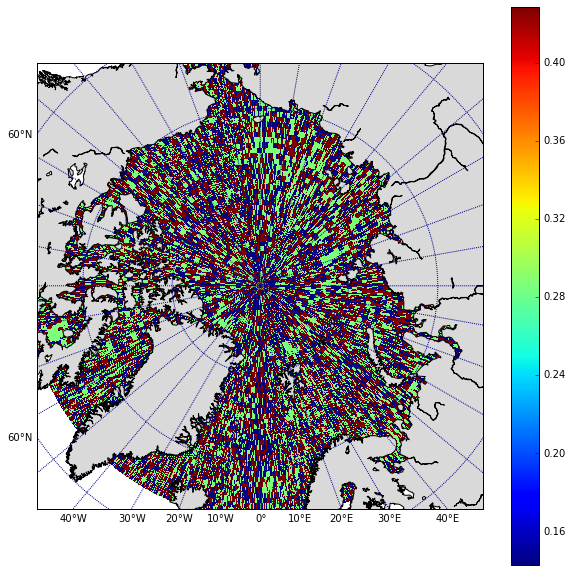

In [45]:
waves = [wave3x,wave3y, wave3diff, wave7x,wave7y,wave7diff,wave11x,wave11y,wave11diff,
         wave13x,wave13y,wave13diff]
waves_title = ['wave3x','wave3y','wave3diff','wave7x','wave7y','wave7diff','wave11x','wave11y'
              ,'wave11diff','wave13x','wave13y','wave13diff']

fig, axes = plt.subplots(4, 3, figsize=(20, 20))

axx = [axes[0][0],axes[0][1],axes[0][2],
       axes[1][0],axes[1][1],axes[1][2],
       axes[2][0],axes[2][1],axes[2][2],
       axes[3][0],axes[3][1],axes[3][2]]

for w,wt, ax in zip(waves,waves_title,axx):
    w = np.ma.masked_where(w[:,:] == 0.0,w)
    cmap = plt.get_cmap('jet')
    cmap.set_bad('burlywood')
    mesh = ax.pcolormesh(w, vmax=0.5,vmin=0.0)
                           #norm=colors.LogNorm(vmin=0.1, vmax=w.max()),cmap=cmap)
    cbar = fig.colorbar(mesh,ax=ax)
    
    ax.set_title(wt)
    plt.axis((0, w.shape[1], 0, w.shape[0]))

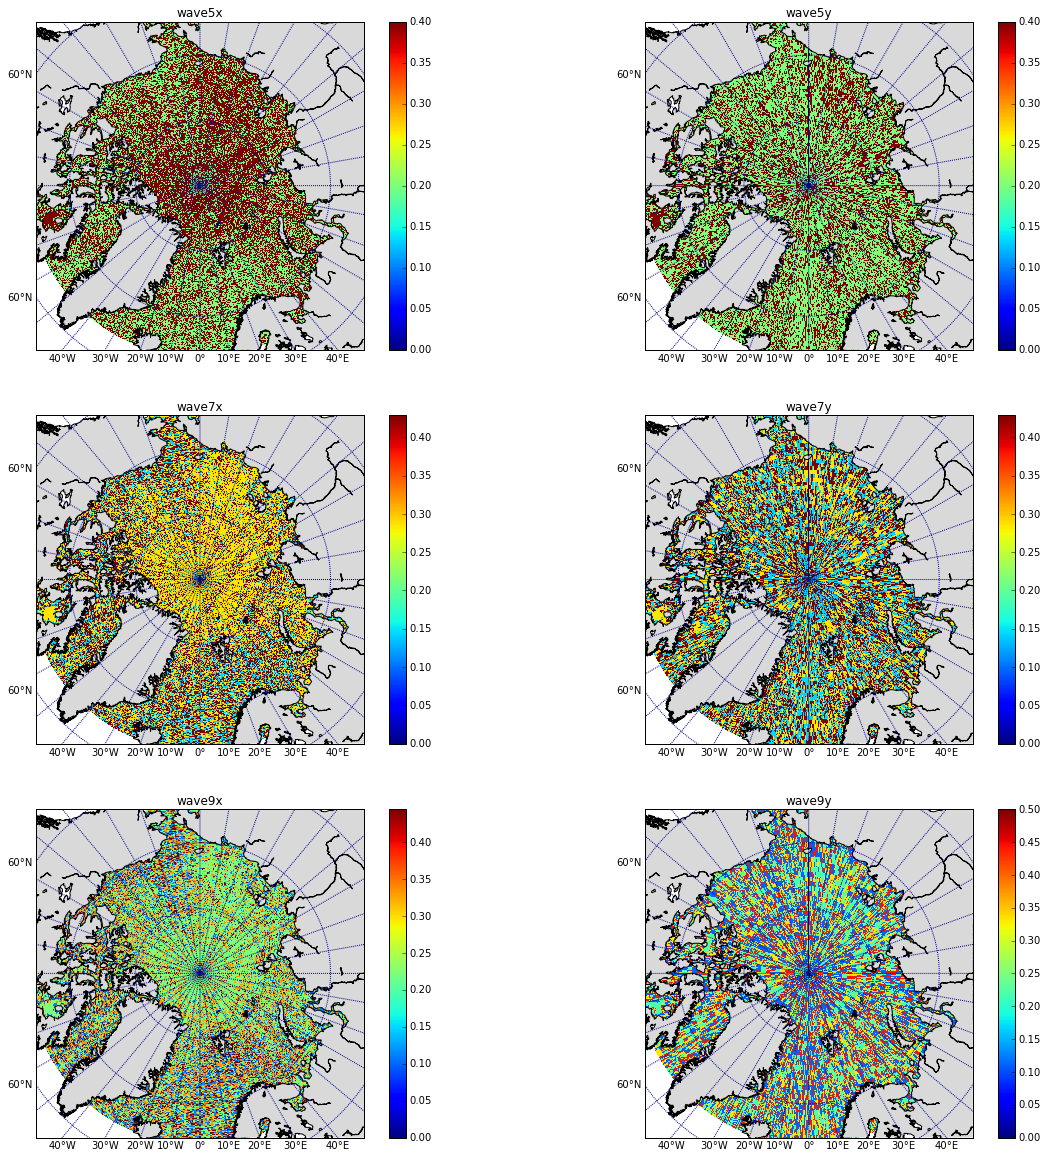

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
cmap = plt.get_cmap('jet')
cmap.set_bad('burlywood')
mesh = ax.pcolormesh(kappa,cmap=cmap)
cbar = fig.colorbar(mesh,ax=ax)
plt.axis((0, kappa.shape[1], 0, kappa.shape[0]))
ax.grid()

ax.set_xlabel('x Index')
ax.set_ylabel('y Index')

In general, the plots above show that as the distance over which kappa is calculated increases the wavenumber decreases, and the wavenumbers for the x direction are higher than for the y direction. 

Spatial variation in wavenumber increases with increasing calculation distance. 